In [15]:
print('Script started...')

Script started...


In [16]:
# Download, preprocess and store data using our own database manager
from database import Database
import os

if not os.path.exists("Database"):
    os.mkdir("Database")
db = Database(os.path.join(os.curdir, "Database"))

all_participants = ["MM05","MM08","MM09","MM10","MM11","MM12","MM14","MM15","MM16","MM18","MM19","MM20","MM21","P02"]
# Warning: One participant is 2-3 GB of data, and ~10 minutes to download, so all of them can take hours
participants_to_load = ["MM05","MM08","MM09","MM10"]
#participants_to_load.remove("P02")

download = False # a quick turn-off switch - so you don't re-process stuff unnecessarily

if download: 
    for participant in participants_to_load:
        db.initialize(participant) # Go and have a coffee, the download takes a while


In [17]:
# Load data from disk
eeg_type = 'speaking'   # options: thinking, speaking, concat
# (whether to use the eeg recording when the participant thought of the syllable, spoke it out loud, or both concatenated)

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = [],[],[],[],[],[]
for participant in participants_to_load:
    tX_train, tX_valid, tX_test, tY_train, tY_valid, tY_test = db.load_data(participant, eeg_type, train_size=0.7, test_size=0.1)
    X_train += tX_train
    X_valid += tX_valid
    X_test += tX_test
    Y_train += tY_train
    Y_valid += tY_valid
    Y_test += tY_test

In [18]:
# Data preparation
from tensorflow.keras.utils import to_categorical
import numpy as np

X_train = np.asarray(X_train).transpose((0,2,1))
X_valid = np.asarray(X_valid).transpose((0,2,1))   # Conv1d needs the last dimension to be the channels
X_test = np.asarray(X_test).transpose((0,2,1))

yset = set(Y_train + Y_valid + Y_test)
phoneme_to_num = (dict((c,i) for i, c in enumerate(yset)))  # dictionaries to convert back and forth
num_to_phoneme = (dict((i,c) for i, c in enumerate(yset)))
num_of_categories = len(phoneme_to_num)

ylist = []
for item in Y_train:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_train = ylist
ylist = []
for item in Y_valid:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories))
Y_valid = ylist
ylist = []
for item in Y_test:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories))
Y_test = ylist

Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)
Y_test = np.asarray(Y_test)

In [19]:
# Let's set up our model and hyperparameter optimizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.backend import clear_session
import keras_tuner
input_length, channels = X_train[0].shape


def build_model(hp):

    clear_session() # I don't know whether this'll clear the GPU memory between optimizer trials, but as long as there's a chance, I'll keep it here
    model = Sequential()
    model.add(Conv1D(hp.Int("filters1", min_value=32, max_value=256, step=32),
    strides = hp.Choice("strides1", [1,3,5,9,16]), kernel_size=hp.Choice('kernel1',[3,5]), activation='relu', input_shape=(input_length, channels)))
    model.add(Dropout(hp.Float('dropout1', 0, 0.5, sampling = "linear")))
    model.add(Conv1D(hp.Int("filters2", min_value=8, max_value=64, step=8), strides = hp.Choice("strides2", [1,3,5,9,16]), kernel_size=hp.Choice('kernel2',[3,5]),
        activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0, 0.5, sampling = "linear")))
    model.add(Conv1D(filters=hp.Int("filters3", min_value=8, max_value=64, step=8), strides = hp.Choice("strides3", [1,3,5]),
        kernel_size=hp.Choice('kernel3',[3,5]), activation='relu'))
    model.add(Dropout(hp.Float('dropout3', 0, 0.5, sampling = "linear")))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(hp.Int('Dense1', 32,256, step = 32), activation = 'relu'))
    model.add(Dense(hp.Int('Dense1', 16,256, step = 16), activation = 'relu'))
    model.add(Dense(num_of_categories, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=hp.Float('learning_rate',1e-4, 1e-2, sampling="log")), metrics=['accuracy'])
    return model


In [20]:
# Setting up the tuner and its built-in logger
from datetime import datetime
time = str(datetime.now()).split('.')[0].replace(':','-')
projectname = time + ' ' + eeg_type + ' - Random search'
tuner_dir = 'tuner'

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory=tuner_dir,
    project_name=projectname)

c:\Users\Andras\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
# Running hyperparameter optimization
import traceback
clear_session() # can't have enough of these :D
try:
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid)) # Let's search for the best model
except:
    traceback.print_exc()   # we want to handle the exception, but also see what happened
    print("Tuner crashed, but let's use the completed trials")
try:
    model = tuner.get_best_models()[0]
except:
    print('It seems like the tuner crashed during the first trial, you probably want to tweak the hyperparameter space')
    raise

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.10810811072587967

Best val_accuracy So Far: 0.10810811072587967
Total elapsed time: 00h 00m 29s
INFO:tensorflow:Oracle triggered exit


In [22]:
# Evaluate and log the best model found by the tuner
from sklearn.metrics import accuracy_score
preds = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(Y_test,axis=1)
path = os.path.join(tuner_dir,projectname, 'best')
if not os.path.exists(path):
    os.mkdir(path)
    
#save model and stats
model.save(os.path.join(path, 'tuner_best_model.hdf5'))
with open(os.path.join(path,'stats.txt'),'w') as myfile:
    myfile.write('Test accuracy: '+ str(accuracy_score(y_true,preds)))
    myfile.write('\n')
    myfile.write(str(tuner.get_best_hyperparameters(1)[0].values))
    myfile.write(str(participants_to_load)) # logging what data we used
# A summary of the hyperparameters of the best model:
model.summary()

2/2 [==============================] - 0s 22ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 96)           17952     
                                                                 
 dropout (Dropout)           (None, 240, 96)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 56)            16184     
                                                                 
 dropout_1 (Dropout)         (None, 15, 56)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 56)             15736     
                                                                 
 dropout_2 (Dropout)         (None, 4, 56)             0         
                                                                 
 max

In [23]:
# Callbacks for further training
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=50, verbose=1)

from keras.callbacks import ModelCheckpoint
retrained_model = os.path.join(path,'retrained_best_model.hdf5')
checkpointer = ModelCheckpoint(filepath=retrained_model, save_best_only=True, verbose=1)

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.8, patience = 20, min_lr=10e-5)

# from keras.callbacks import LearningRateScheduler
# def scheduler(epoch):
#     result = 0.1
#     if epoch>30:
#         result = 0.05
#     if epoch > 60:
#         result = 10e-3
#     return result
# change_lr = LearningRateScheduler(scheduler)

# from keras.callbacks import TensorBoard
# tensorboard_callback = TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

from keras.callbacks import Callback
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}): # clear
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}): # save on every epoch
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('accuracy'))
        self.valid_accs.append(logs.get('val_accuracy'))
        self.epoch +=1

history = TrainingHistory()

In [24]:
# Let's train the model further
clear_session()
batchsize = 16
while True:
    try:
        model.fit(X_train, Y_train, epochs=100, batch_size=batchsize, validation_data=(X_valid, Y_valid), verbose=2, # we might want to optimize batch size in the future
            callbacks = [  
            early_stopping,
            reduce_lr,
            history,
            #tensorboard_callback,
            #change_lr,
            checkpointer
            ], shuffle = True)
        break
    except:
        if batchsize >1:
            batchsize = batchsize / 2   # reduce the batch size until the net fits into GPU memory - a bit of a makeshift solution
        else:
            raise

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.40624, saving model to tuner\2022-12-11 22-12-19 speaking - Random search\best\retrained_best_model.hdf5
25/25 - 1s - loss: 2.4018 - accuracy: 0.0646 - val_loss: 2.4062 - val_accuracy: 0.1171 - lr: 0.0085 - 897ms/epoch - 36ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 2.40624
25/25 - 0s - loss: 2.4009 - accuracy: 0.0879 - val_loss: 2.4125 - val_accuracy: 0.0631 - lr: 0.0085 - 219ms/epoch - 9ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 2.40624
25/25 - 0s - loss: 2.3985 - accuracy: 0.0930 - val_loss: 2.4096 - val_accuracy: 0.0901 - lr: 0.0085 - 210ms/epoch - 8ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 2.40624
25/25 - 0s - loss: 2.3986 - accuracy: 0.0672 - val_loss: 2.4114 - val_accuracy: 0.0901 - lr: 0.0085 - 213ms/epoch - 9ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 2.40624
25/25 - 0s - loss: 2.3969 - accuracy: 0.1008 - val_loss: 2.4189 - val_accuracy: 0.0541 - lr: 0.0085 

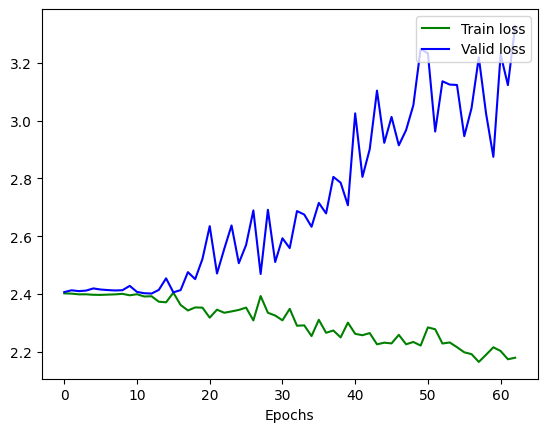

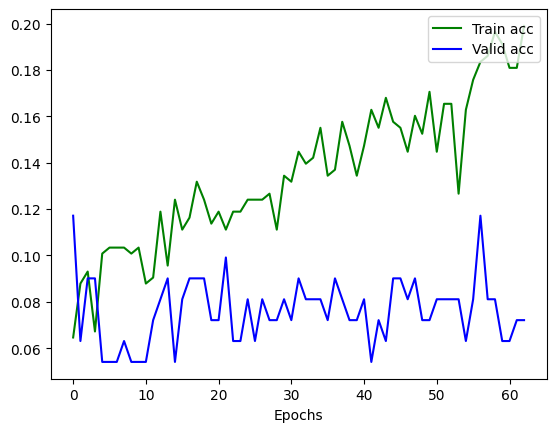

In [25]:
# Let's plot how the retraining went:
import matplotlib.pyplot as plt
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Train loss') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Valid loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()
plt.plot(np.arange(history.epoch), history.accs, color ='g', label='Train acc') 
plt.plot(np.arange(history.epoch), history.valid_accs, color ='b', label='Valid acc')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [26]:
# Load best model:
from tensorflow.keras.models import load_model
model = load_model(retrained_model)

2/2 [==============================] - 0s 5ms/step


C:\Users\Andras\AppData\Local\Temp\ipykernel_11812\1541144622.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(phoneme_to_num)
C:\Users\Andras\AppData\Local\Temp\ipykernel_11812\1541144622.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(phoneme_to_num)


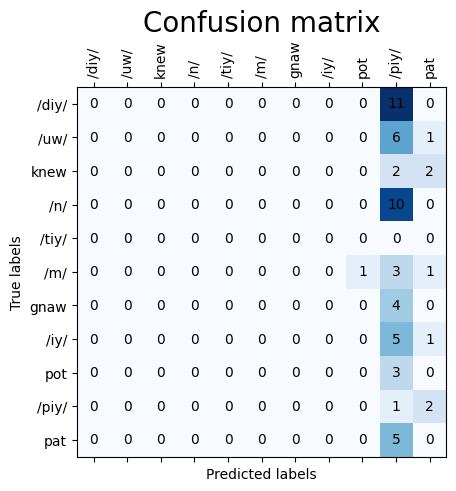

EEG type: speaking
Test accuracy:  0.017241379310344827
Precision 0.002
Recall 0.03333333333333333
f1_score 0.0037735849056603774


c:\Users\Andras\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Test accuracy and confusion matrix - and a few more metrics that might come in handy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

preds = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(Y_test,axis=1)

conf = confusion_matrix(y_true, preds,labels = list(num_to_phoneme))

def plotmatrix(title, intersection_matrix): # plot the matrix
    it = range(num_of_categories)
    fig, ax = plt.subplots(constrained_layout=True)
    ax.set_title(title, fontdict={'fontsize': 20})

    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(phoneme_to_num)
    ax.set_yticklabels(phoneme_to_num)
    plt.xticks(rotation=90)
    ax.set_xticks(it)
    ax.set_yticks(it)

    for i in it:
        for j in it:
            c = intersection_matrix[j, i]
            ax.text(i, j, str(round(c, 2)), va='center', ha='center')

plotmatrix('Confusion matrix', conf)
plt.show()

print('EEG type: ' + eeg_type)
acc = accuracy_score(y_true,preds)
print('Test accuracy: ', acc)
print("Precision", precision_score(y_true, preds, average="macro"))
print("Recall", recall_score(y_true, preds, average="macro"))
print("f1_score", f1_score(y_true, preds, average="macro"))
with open(os.path.join(path,'stats.txt'),'a') as myfile:
    myfile.write('\n\n')
    myfile.write('Test accuracy after retraining: '+ str(acc))

In [28]:
# in case we turn it on later
#%load_ext tensorboard
#%tensorboard --logdir logs